# 1. Importing the data from csv file and plotting glucose readings along with meal times


Total number of glucose readings is: 7633

Some of points may be missing, the above number represents the collected readings from start to end date

Remove NaN from the mg/dL column... 
Total actual number of glucose readings is: 6092

Remove NaN from the CHO so we can plot the points of meals...
Total number of meal times: 253

Some of the successive meal readings are redundant and stand for one meal only

Remove redundant readings of same meal...

There are 93  unredundant recorded glucose readings with meal times.

                 Date  mg/dL  CHO (g)  Fat (g)  Protein (g)
0 2008-07-01 09:43:00   82.0   27.500    0.000        7.000
1 2008-07-01 12:43:00   54.0   14.500    2.750        3.375
2 2008-07-01 14:58:00   86.0    7.000    0.000        5.000
3 2008-07-01 17:58:00   88.0    9.466    3.604        3.324
4 2008-07-02 08:58:00   99.0   27.500    0.000        7.000


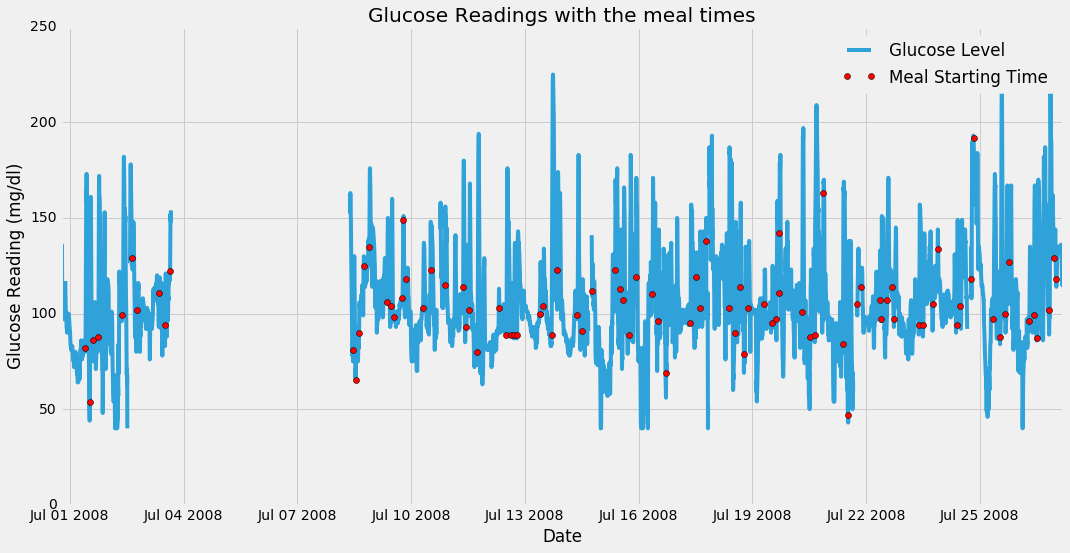

In [210]:
#This was written in Python 2, if you are running Python 3, use a code translation library

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date, time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math

%matplotlib inline
#This is graph line style, from Nate silver
plt.style.use('fivethirtyeight')

#_DATA_DIR = r'/Users/administrator/Desktop/New Git Diabetes/Input/input'
#_FIG_DIR = r'/Users/administrator/Desktop/New Git Diabetes/figures'
_DATA_DIR = r'C:\Users\engadmin\Desktop\Diabetes  Project Code\Input\input'
_FIG_DIR = r'C:\Users\engadmin\Desktop\Diabetes  Project Code\figures'

if not os.path.exists(_FIG_DIR):
    os.makedirs(_FIG_DIR)
    
_GULCOSE_DATA_PATH = os.path.join(_DATA_DIR, 'P1.csv')
fields = ["Date", "mg/dL", "CHO (g)", "Fat (g)", "Protein (g)"]
df_P1 = pd.read_csv(_GULCOSE_DATA_PATH, parse_dates=['Date'], usecols = fields) #read and prase Date col as dataTimes object
df_P1 = df_P1.sort(['Date'])

## Matplotlib Variables
_FIG_SIZE = (16, 8)
_FIG_FORMAT = 'png'
_FIG_DPI = 200

def _file_format(string_):
    string_ = string_.replace('-', '_').replace(' ', '_').replace('$', '')
    string_ += '.' + _FIG_FORMAT
    return string_

print "\nTotal number of glucose readings is:", df_P1['mg/dL'].size
print "\nSome of points may be missing, the above number represents the collected readings from start to end date"

#Removing NaN from a specific column of the dataframe, here it's mg/dL
df_P1_wonan_mg = df_P1.dropna(subset=['mg/dL'])
print "\nRemove NaN from the mg/dL column...", "\nTotal actual number of glucose readings is:", df_P1_wonan_mg['mg/dL'].size

#Converting object type to float for all of the dataframe
df_P12= pd.DataFrame(df_P1_wonan_mg).convert_objects(convert_numeric=True)

print "\nRemove NaN from the CHO so we can plot the points of meals..."
df_P12 = df_P12.dropna(subset=['CHO (g)'])
print "Total number of meal times:", df_P12['CHO (g)'].size

print "\nSome of the successive meal readings are redundant and stand for one meal only"

df_P12 = df_P12.reset_index(drop=True)

df_P1_meals = copy.deepcopy(df_P12)

print '\nRemove redundant readings of same meal...\n' 
row = 0
for i, x in enumerate(df_P12['CHO (g)']):
        if i > 0:
            row = row + 1
            #if content of current element is same as previous, then delete row      
            if x == df_P12['CHO (g)'][i-1]:
                df_P1_meals.drop(df_P1_meals.index[row], axis=0, inplace=True)
                row = row - 1
                
df_P1_meals = df_P1_meals.reset_index(drop=True)
print "There are", df_P1_meals['CHO (g)'].size, " unredundant recorded glucose readings with meal times.\n" 

print df_P1_meals.head()

plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df_P1.Date, df_P1['mg/dL'], '-', label="Glucose Level");
plt.plot_date(df_P1_meals.Date, df_P1_meals['mg/dL'], 'ro', label="Meal Starting Time")
plt.xlabel('Date')
plt.ylabel('Glucose Reading (mg/dl)')
plt.legend(loc='upper right')
title = 'Glucose Readings with the meal times'
plt.title(title);

# Patient meal sizes histogram 

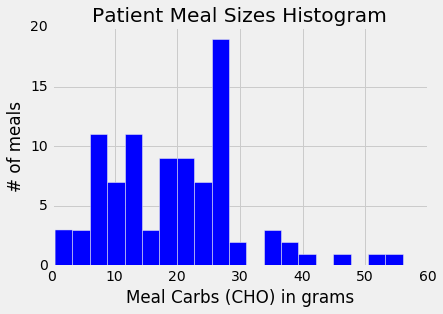

In [211]:
n, bins, patches = plt.hist(df_P1_meals['CHO (g)'], 20, facecolor='blue', alpha=1)
plt.title('Patient Meal Sizes Histogram')
plt.xlabel('Meal Carbs (CHO) in grams')
plt.ylabel('# of meals')
plt.show()

# Interactive Plotting of the data

In [212]:
#Interactive plotting using bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models.markers import Asterisk
from bokeh.models import ColumnDataSource, DataRange1d, Plot, LinearAxis, Grid
from bokeh.models import HoverTool

# output to static HTML file
output_file("All_Data.html")

plot = figure(plot_width=1250, plot_height=600, title="Glucose Readings Interactive Plot",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

s1 = plot.line(df_P1.Date, df_P1['mg/dL'],  line_width=2, line_alpha=0.6)
s2 = plot.square(df_P1.Date, df_P1['mg/dL'], legend="Glucose Readings", fill_color=None, line_color="grey")

source = ColumnDataSource(dict(x=df_P1_meals.Date, y=df_P1_meals['mg/dL'], z=df_P1_meals['CHO (g)'], k = df_P1_meals['Fat (g)'], d = df_P1_meals['Protein (g)']))

glyph_1 = Asterisk(x="x", y="y", line_color="#f0027f", fill_color=None, line_width=8)
s3 = plot.add_glyph(source, glyph_1)

plot.add_tools(HoverTool(renderers=[s3], tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('Meal Size (grams)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Date & Time"
plot.yaxis.axis_label = "Glucose Reading (mg/dL)"

show(plot)

# Critical Assumptions for Cleaning Data

## 1. Assumption for Deletion

**a. Delete meal times that have several missing glucose readings following them.**

We may consider keeping these points later if we are interstd on the meal times only and not the readings following them.

The window that is selected is under window_size. i.e: 17 represents a window of (17*5) + 5 = 90 mintues

In [213]:
import datetime

df_P1_meals_w_deletion = copy.deepcopy(df_P1_meals)

#variables
incr = 5 #Data was recorded at 5 minutes increments
window_size = 17 #This represents window size based on increments of 5.

del_points_df1 = pd.DataFrame()#Dataframe containing meal to be deleted by this assumption
points_to_del1 = []

for x in range(df_P1_meals_w_deletion['CHO (g)'].size):
    a = df_P1_meals_w_deletion['Date'][x]
    b = a
    count = 0
    for j in range(window_size):
        b += datetime.timedelta(minutes=incr)
        reading = df_P1.loc[df_P1['Date'] == b]['mg/dL']
        try:
            reading.values[0]
        except IndexError:
            #print "Index out of range"
            count +=1 
            continue  
        if (math.isnan(reading.values[0])):
            count +=1
    if (count > (window_size/2)):
        print "\nThe meal time at", a, "has", count,"missing readings within its {}".format((window_size*5)+5),"minutes. Thus, it will be removed from the dataset.\n"
        #Put this into a dataframe to plot later with different color
        del_points_df1 = del_points_df1.append(df_P1.loc[df_P1['Date'] == a])        
        points_to_del1.extend([x])  

#Remove the above detected points from dataset
df_P1_meals_w_deletion.drop(df_P1_meals_w_deletion.index[points_to_del1],axis=0,inplace=True)
df_P1_meals_w_deletion = df_P1_meals_w_deletion.sort(['Date'])
df_P1_meals_w_deletion = df_P1_meals_w_deletion.reset_index(drop=True)

print "There are", df_P1_meals_w_deletion['CHO (g)'].size, "remaining meal times recordings.\n" 

#print points_to_del1


The meal time at 2008-07-03 15:28:00 has 11 missing readings within its 90 minutes. Thus, it will be removed from the dataset.

There are 92 remaining meal times recordings.



**The dataframe that contains the meal times to be deleted after this assumption is: del_points_df1**



**b. Delete meal times which all following readings are decreasing or have no sign of a significant increase (i.e: 15mg/dl).**

Comparing every glucose reading starting few minutes before the meal was recorded, just in case the meal was recorded minutes later, and checking if there is a significant increase in **its** following "glucose_effect_window" (i.e 45 minutes).

For instance, a reading situated 30 minutes after meal time which has a following glucose increase of (15mg/dl in total) after 40minutes will result on keeping that original meal time which was (40mins + 30mins before).

For "effect_window" of 45minutes implies that we are checking for an increase up to one hour and a half after meal time.

If no significant increase is apparent, we delete the meal point.

In [214]:
#Note: Make sure to run the previous cell before running this one since the dataframe here used will be overwitten at end of this cell

#variables
incr = 5 #Data was collected at 5 minutes increments- Do not change this
glucose_effect_window = 45 #Minutes food may take to be reflected on the blood glucose
gl_increase_window = 30 #Minutes from the instance where the glucose is reflected on the blood to significant increase
pre_recording_mins = 20 #Minutes that may have elapsed before patient has recorded the reading
gl_increase = 15 #20mg/dL increase

########May want to change VARIABLES above for different patients, especially if food takes a while to affect their glucose level############
meal_affect_window = [i for i in np.arange(-(pre_recording_mins), glucose_effect_window+incr, incr)]

compare_window = [j for j in np.arange(incr, gl_increase_window+incr, incr)]
################################################################

#print meal_affect_window
#print compare_window

points_to_del = []
del_points_df = pd.DataFrame()#Dataframe containing meal to be deleted by this assumption
low_surrounding_gl = pd.DataFrame()#Dataframe containing points where the glucose will take a significant increase, not necessarily the very lowest points
offset_low_point_to_meal = []

for x, item in enumerate(df_P1_meals_w_deletion['CHO (g)']):
    
    a = df_P1_meals_w_deletion['Date'][x]   
    meal_reading = df_P1.loc[df_P1['Date'] == a]['mg/dL']
    b = a - datetime.timedelta(minutes=pre_recording_mins)
    
    keep = 0
    for i in meal_affect_window:
        current_reading = df_P1.loc[df_P1['Date'] == b]['mg/dL']
        try:
            current_reading.values[0]
        except IndexError:
            #print "Index out of range"
            b += datetime.timedelta(minutes=incr)   
            continue
            
        if (math.isnan(current_reading.values[0])):
            b += datetime.timedelta(minutes=incr)  
            continue            
        c = b
        for k in compare_window:#comparing the point with its following readings in compare window size
            c += datetime.timedelta(minutes=incr)
            compare_reading = df_P1.loc[df_P1['Date'] == c]['mg/dL']
            if ((compare_reading.values[0] - current_reading.values[0]) >gl_increase):
                #print "We should keep this reading"
                #Store this reading on a dataframe of low readings surrounding meals
                low_surrounding_gl = low_surrounding_gl.append(df_P1.loc[df_P1['Date'] == b])
                #print "a is:", a, "and b is:", b, "and c is:", c, "and difference between b and c is:", (c - b)
                if (b<=a):
                    offset_low_point_to_meal.extend([int(-(a-b).seconds / 60)])
                    #print "The time elapsed between original meal time and surrounding low point is:", "-", (a-b).seconds / 60 ,"minutes."        
                else:
                    offset_low_point_to_meal.extend([int((b-a).seconds / 60)])
                    #print "The time elapsed between original meal time and surrounding low point is:", "+", (b-a).seconds / 60 ,"minutes."  
                #offset_low_point_to_meal.extend([offset_seconds])
                keep = 1  
                break
                
        if (keep == 1):
            break
        b += datetime.timedelta(minutes=incr)    
        
        if (i == meal_affect_window[-1]):
            #print "The meal reading taken at" ,a, "should be deleted."
            #Put this into an dataframe to plot with different color
            del_points_df = del_points_df.append(df_P1.loc[df_P1['Date'] == a])
            #Also remove this from dataset   
            points_to_del.extend([x])                     

#print "\nThe dataframe of the points to be deleted is:\n", del_points_df 

#print (points_to_del)

print "\nThere are", len(points_to_del), "that will be deleted"

df_P1_meals_w_deletion.drop(df_P1_meals_w_deletion.index[points_to_del],axis=0,inplace=True)
df_P1_meals_w_deletion = df_P1_meals_w_deletion.sort(['Date'])
df_P1_meals_w_deletion = df_P1_meals_w_deletion.reset_index(drop=True)

print "\nThere are", df_P1_meals_w_deletion['CHO (g)'].size, "remaining meal times recordings." 

low_surrounding_gl = low_surrounding_gl.sort(['Date'])
low_surrounding_gl = low_surrounding_gl.reset_index(drop=True)

#print "The difference between each recorded meal and surrounding point which has a following significant increase is (in minutes):\n"
#print offset_low_point_to_meal
#It is mostly (-20minutes) because we start checking 20 minutes previous to the recorded meal


There are 8 that will be deleted

There are 84 remaining meal times recordings.


**The dataframe that contains the meal times to be deleted after this assumption is: del_points_df**

**In the below interactive Bokeh plotting: Plotting all the meal points along with the ones to be deleted with different colors.**

**Red = Points to be kept**

**Green = Points to be deleted based on assumption 1.a**
  
**Blue = Points to be deleted based on assumption 1.b**

In [215]:
def handle_case():
    print "This dataframe does not have missing glucose readings following any meal time"

# output to static HTML file
output_file("All_Data_with_Deletion.html")

plot = figure(plot_width=1250, plot_height=600, title="Glucose Readings Interactive Plot",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

plot.line(df_P1.Date, df_P1['mg/dL'],  line_width=2, line_alpha=0.6)
plot.square(df_P1.Date, df_P1['mg/dL'], legend="Glucose Readings", fill_color=None, line_color="grey")

good_readings = ColumnDataSource(dict(x=df_P1_meals_w_deletion.Date, y=df_P1_meals_w_deletion['mg/dL'], z=df_P1_meals_w_deletion['CHO (g)'], k = df_P1_meals_w_deletion['Fat (g)'], d = df_P1_meals_w_deletion['Protein (g)']))
glyph_1 = Asterisk(x="x", y="y", line_color="#f0027f", fill_color=None, line_width=8)
g1 = plot.add_glyph(good_readings, glyph_1)

if (len(points_to_del1) == 0):
    handle_case()
else: 
    delete_readings_1a = ColumnDataSource(dict(x=del_points_df1.Date, y=del_points_df1['mg/dL'], z=del_points_df1['CHO (g)'], k = del_points_df1['Fat (g)'], d = del_points_df1['Protein (g)']))
    glyph_2 = Asterisk(x="x", y="y", line_color="#32CD32", fill_color=None, line_width=8)
    g2 = plot.add_glyph(delete_readings_1a, glyph_2)

if (len(points_to_del) == 0):
    handle_case()
else:        
     delete_readings_1b = ColumnDataSource(dict(x=del_points_df.Date, y=del_points_df['mg/dL'], z=del_points_df['CHO (g)'], k = del_points_df['Fat (g)'], d = del_points_df['Protein (g)']))
     glyph_3 = Asterisk(x="x", y="y", line_color="#0404B4", fill_color=None, line_width=8)
     g3 = plot.add_glyph(delete_readings_1b, glyph_3)

#print y
plot.add_tools(HoverTool(renderers=[g1, g2,g3], tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('CHO (g)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Date & Time"
plot.yaxis.axis_label = "Glucose Reading (mg/dL)"

show(plot) 

**This completes the assumptions for deleting abnormal meal points**

## 2. Assumption for Adjusting Meal times: Finding surrounding lowest glucose level

Extract lowest glucose reading surrounding the meal time, this is usually the point of glucose increase effect affect after meal. The window can be a variable, we are using [-20mins to +45mins] of the meal time.

By extracting these points, we can estimate that the true meal times happened few minutes right before these points (usually 0 mins to 30 mins before)

**Finding the lowest glucose level surrounding the recorded meal time**

1. Find a significant blood glucose increase surrounding the recorded meal time, say 15mg/dl. 

2. Find the lowest point before that increase. That's what we will consider in our future processing.

**Below is the dataframe that contains low glucose levels surrounding meal times, which have a significant following glucose increase.** Not only the surrounding lowest readings, but it must have a close upcoming glucose increase to it.

[ 10 -10  25 -20  40  10 -20 -10  15   5   0 -20 -20   5   5 -20 -10 -20
  -5   0  -5  -5  -5 -15  -5 -20 -20  -5  -5 -10 -10  -5 -20  15   0   5
  50 -15  10   0 -10  -5 -10 -15 -15 -10 -20 -20  -5 -10 -20 -20  20 -10
 -10  15   5 -20   0 -20  -5 -20 -10   5  15  -5  -5 -20  -5 -10 -20 -10
 -20 -20  15  10  -5  -5  25 -20 -15 -10 -15  20]

The mean of the time elapsed between recorded meal time and convenient surrounding lowest point is -4.94 minutes 
with a std of 14.40 minutes.


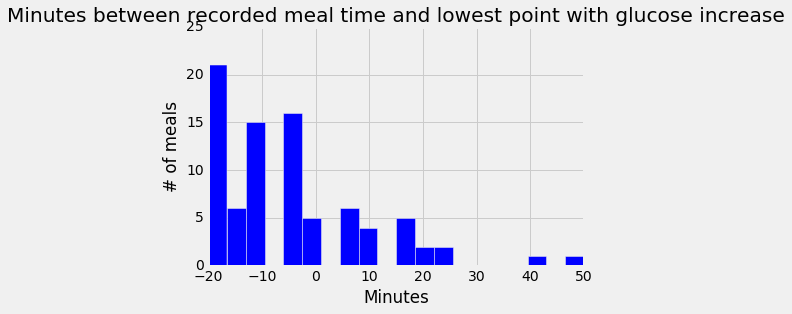

In [216]:
gl_increase_window = [j for j in np.arange(0, glucose_effect_window+incr, incr)]

offset_lowest_point_to_meal = []
offset_highest_point_to_meal = []
points_to_readjust = []

readjust_points_df = pd.DataFrame()
surrounding_lowest_points_df = pd.DataFrame()

for x in range(low_surrounding_gl['CHO (g)'].size):
    a = low_surrounding_gl['Date'][x]
    b = a
    min_reading = df_P1.loc[df_P1['Date'] == a]['mg/dL']
    max_reading = df_P1.loc[df_P1['Date'] == a]['mg/dL']
    lowest_pt_index = 0
    highest_pt_index = 0
    #print "For meal time of index", x
    for i,y in enumerate(gl_increase_window):
        #get the lowest point within the full window
        current_reading = df_P1.loc[df_P1['Date'] == b]['mg/dL'].values[0]
        try:
            current_reading
        except IndexError:
            print "Index out of range"
            b += datetime.timedelta(minutes=incr)   
            continue
        
        if (math.isnan(current_reading)):
            b += datetime.timedelta(minutes=incr)  
            continue
            
        #print "The current lowest reading is:", min_reading.values[0], "and compared reading is:", current_reading, "and y is:", y
        if (current_reading<min_reading.values[0]):  
            min_reading = df_P1.loc[df_P1['Date'] == b]['mg/dL'] 
            lowest_pt_index = y 
        elif (current_reading>max_reading.values[0]):  
            max_reading = df_P1.loc[df_P1['Date'] == b]['mg/dL'] 
            highest_pt_index = y  
        b += datetime.timedelta(minutes=incr) 
    #print x,": At date", a, "the lowest point is", min_reading.values[0], "of index", lowest_pt_index, "and the highest point is", max_reading.values[0], "of index",highest_pt_index 
    #These points need to be readjusted, see picture below
    offset_lowest_point_to_meal.extend([lowest_pt_index])
    offset_highest_point_to_meal.extend([highest_pt_index])
    #print "x:",x,"Add", lowest_pt_index, "minutes to the date", a
    surrounding_lowest_points_df = surrounding_lowest_points_df.append(df_P1.loc[df_P1['Date'] == (a + datetime.timedelta(minutes=lowest_pt_index))])   

surrounding_lowest_points_df = surrounding_lowest_points_df.sort(['Date'])
surrounding_lowest_points_df = surrounding_lowest_points_df.reset_index(drop=True)
    
#The real time difference between the lowest point and meal time is the addition of difference between meal time and low surrounding point + between low surrounding point and lowest surrounding point
        
offset_meal2increase = np.add(offset_lowest_point_to_meal , offset_low_point_to_meal)    
    
#print offset_meal2increase

print "\nThe mean of the time elapsed between recorded meal time and convenient surrounding lowest point is %.2f" %np.mean(offset_meal2increase), "minutes \nwith a std of %.2f" %np.std(offset_meal2increase), "minutes."

#print "\nThe mean of the time elapsed difference between recorded meal time and surrounding peak point is %.2f" %np.mean(offset_highest_point_to_meal), "minutes \nwith a std of %.2f" %np.std(offset_lowest_point_to_meal), "minutes."

n, bins, patches = plt.hist(offset_meal2increase, 20, facecolor='blue', alpha=1)
plt.title('Minutes between recorded meal time and lowest point with glucose increase')
plt.xlabel('Minutes')
plt.ylabel('# of meals')
plt.show()

**The dataframe that contains the meal times after deletion of abnormal meal recordings is: df_P1_meals_w_deletion**

**The dataframe that contains the lowest surrounding points with significant glucose increase is: surrounding_lowest_points_df**

In [227]:
after_reading = 300 #size of the plot after meal time in minutes
Plot_window = [i for i in np.arange(-(pre_recording_mins), after_reading+incr, incr)]

#This includes all steps for correct plotting
def Plot_extraction_v2(df_P1_w_all_deletion, df_all_plots_v2):
    for x in range(df_P1_w_all_deletion['CHO (g)'].size):
        #save the readings surrounding every meal time in a new dataframe
        a = df_P1_w_all_deletion['Date'][x]
        
        #Check if it's last reading
        if (x<((df_P1_w_all_deletion['CHO (g)'].size))-1):
            a1 = df_P1_w_all_deletion['Date'][x+1]          

            b = a - datetime.timedelta(minutes=pre_recording_mins)
            reading_list = []
            for j in Plot_window:
                reading = df_P1.loc[df_P1['Date'] == b]['mg/dL']       
                try:
                    reading.values[0]
                except IndexError:
                    #print "Index out of range"
                    reading_list.append(float('nan'))
                    b += datetime.timedelta(minutes=incr)   
                    continue
                #Check to include points only up to next meal time, else put nan on that array so they are not plotted
                if ((a1 - b).total_seconds() < 0 ):#readings_distance = (a1 -a).total_seconds()/60 #The elapsed time in minutes 
                    #print "Elapsed time on this iteration is less than the full window time", x
                    reading_list.append(float('nan'))
                    b += datetime.timedelta(minutes=incr)
                    continue
                else:
                    #store this value on the jth column of xth row of the new dataframe
                    reading_list.append(reading.values[0])
                    b += datetime.timedelta(minutes=incr)
        else: 
            #plot readings until next meal, need to replace that row
            b = a - datetime.timedelta(minutes=pre_recording_mins)
            reading_list = []
            for j in Plot_window:
                reading = df_P1.loc[df_P1['Date'] == b]['mg/dL']       
                try:
                    reading.values[0]
                except IndexError:
                    #print "Index out of range"
                    reading_list.append(float('nan'))
                    b += datetime.timedelta(minutes=incr)   
                    continue
                #store this value on the jth column of xth row of the new dataframe
                reading_list.append(reading.values[0])
                b += datetime.timedelta(minutes=incr)
        #print reading_list
        #print df_all_plots.shape
        df_all_plots_v2.loc[x]=reading_list

    #print df_all_plots_v2

In [257]:
def plotting(df_all_plots_v2, df_P1_w_all_deletion):

    plt.figure(figsize=(20,12))
    for j in range(25,30):
    #for j in range(len(df_P1_w_all_deletion)):
        row = df_all_plots_v2.iloc[j]
        #print row
        row.plot(label='Meal Time at {}'.format(df_P1_w_all_deletion['Date'][j]))
        #Recorded meal time reading
        plt.plot(0, df_all_plots_v2[0][j], 'ro', markersize=10)
        #Lowest surrounding point of increase
        plt.plot(offset_meal2increase[j], surrounding_lowest_points_df['mg/dL'][j], 'b^', markersize=15)
        
    plt.xlabel('Minutes')
    plt.ylabel('Glucose Reading (mg/dl)')
    plt.legend(loc='upper right')
    title = 'Glucose Lelvel Readings {} minutes after meal recording or until next meal recording'.format(after_reading)
    plt.title(title);

    #Uncomment below to save plot
    #plt.savefig('Patient_1_Plotsaftermeal_iter0to5.png')

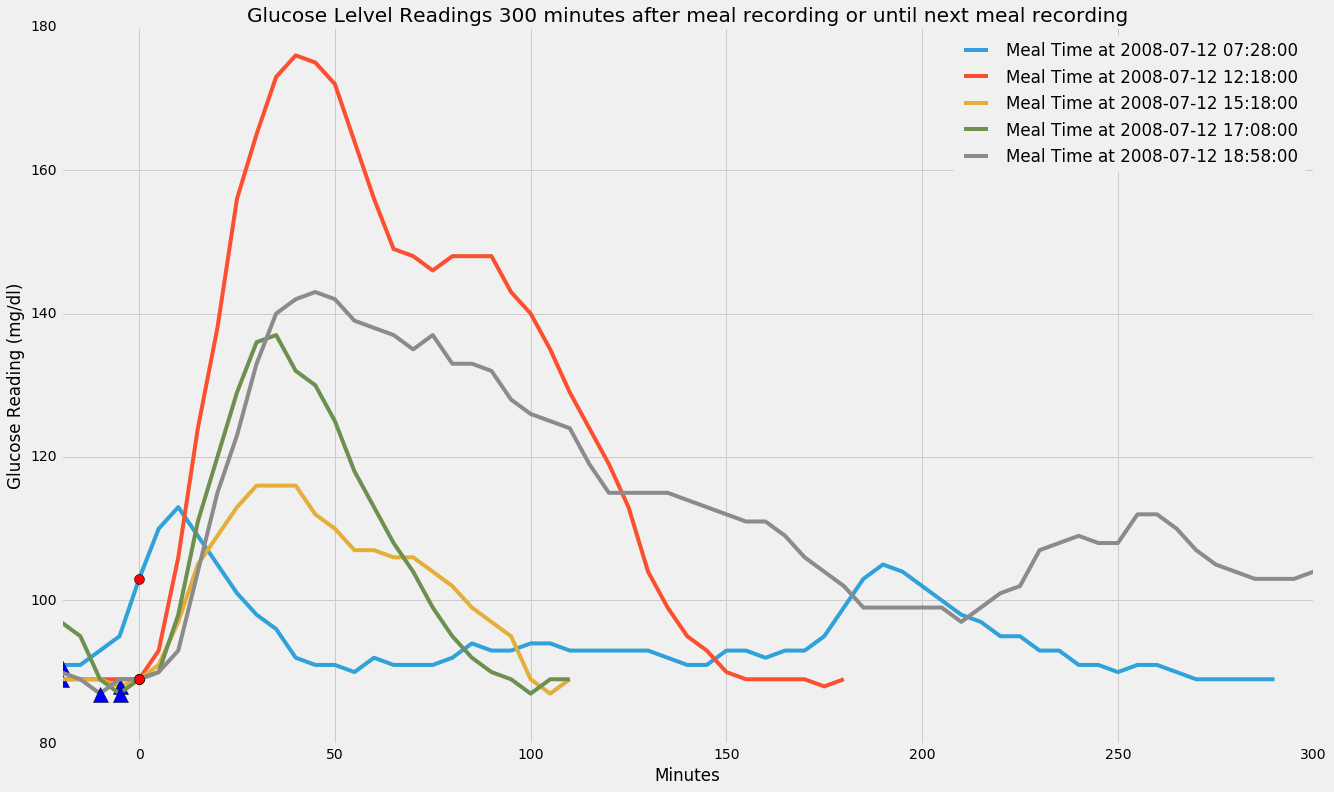

In [258]:
df_all_plots_v2 = pd.DataFrame(columns=Plot_window)

Plot_extraction_v2(df_P1_meals_w_deletion, df_all_plots_v2)
plotting(df_all_plots_v2, df_P1_meals_w_deletion)
